<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com) for PyCon 2015. Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_pycon2015/).</i></small>

<small><i>With updates by Volh Hedranovich.</i></small>

# Density Estimation: Gaussian Mixture Models

Here we'll explore **Gaussian Mixture Models**, which is an unsupervised clustering & density estimation technique.

We'll start with our standard set of initial imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import HTML
from scipy import stats
from sklearn.mixture import GaussianMixture

import seaborn as sns; sns.set()

In [2]:
sns.set_style("whitegrid")
sns.set_palette((sns.color_palette("Paired")))

## Introducing Gaussian Mixture Models

We previously saw an example of K-Means, which is a clustering algorithm which is most often fit using an expectation-maximization approach.

Here we'll consider an extension to this which is suitable for both **clustering** and **density estimation**.

For example, imagine we have some one-dimensional data in a particular distribution:

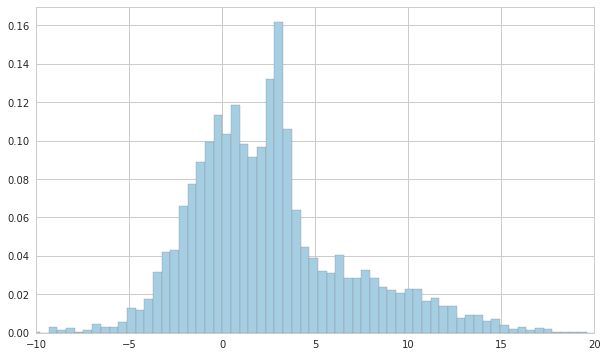

In [3]:
np.random.seed(2)
x = np.concatenate([np.random.normal(0, 2, 2000), #(loc=0.0, scale=1.0, size=None) - Mean, Standard deviation, Shape
                    np.random.normal(5, 5, 2000),
                    np.random.normal(3, 0.5, 600)])
plt.figure(figsize=(10, 6))
plt.hist(x, 80, normed=True, ec='gray')
plt.xlim(-10, 20);

Gaussian mixture models will allow us to approximate this density:

In [4]:
x_init = x.copy()
x = x.reshape(-1, 1)
clf = GaussianMixture(n_components=5, max_iter=500, random_state=3).fit(x)

In [5]:
# (start, stop, num) Returns `num` evenly spaced samples, calculated over the interval [`start`, `stop`].
xpdf = np.linspace(-10, 20, 1000).reshape(-1, 1) 

density = np.exp(clf.score_samples(xpdf))

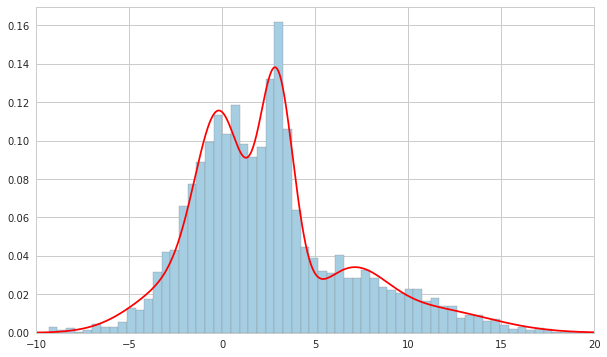

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(x, 80, normed=True, ec='gray')
plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20);

Note that this density is fit using a **mixture of Gaussians**, which we can examine by looking at the ``means_``, ``covars_``, and ``weights_`` attributes:

In [7]:
clf.means_

array([[-2.19678832],
       [ 6.83864525],
       [ 2.90431516],
       [-0.11538351],
       [11.12803776]])

In [8]:
clf.covariances_

array([[[ 5.67456237]],

       [[ 3.74726274]],

       [[ 0.86800422]],

       [[ 1.67734391]],

       [[10.11804256]]])

In [9]:
print(clf.weights_)
clf.weights_.sum()

[0.15671604 0.14035437 0.29106383 0.314459   0.09740675]


0.9999999999999992

In [10]:
clf.n_components

5

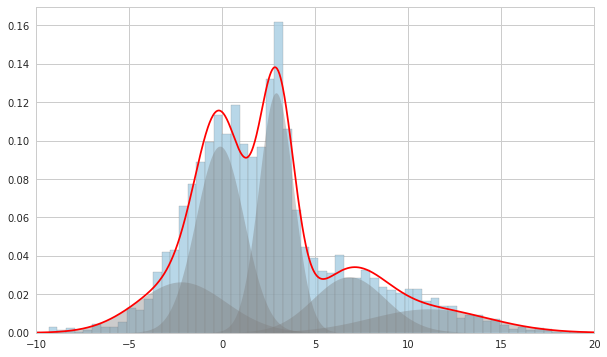

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(x, 80, normed=True, alpha=0.8, ec='gray')
plt.plot(xpdf, density, '-r')

for i in range(clf.n_components):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0],
                                       np.sqrt(clf.covariances_[i, 0])).pdf(xpdf)
    plt.fill(xpdf, pdf, facecolor='gray',
             edgecolor='none', alpha=0.4)
plt.xlim(-10, 20);

These individual Gaussian distributions are fit using an expectation-maximization method, much as in K means, except that rather than explicit cluster assignment, the **posterior probability** is used to compute the weighted mean and covariance.
Somewhat surprisingly, this algorithm **provably** converges to the optimum (though the optimum is not necessarily global).

## Some examples

In [12]:
HTML('<img src="examples/Em_old_faithful.gif">')

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [13]:
HTML('<img src="examples/mixture-iterations.gif">')

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


## How many Gaussians?

Given a model, we can use one of several means to evaluate how well it fits the data.
For example, there is the Aikaki Information Criterion (AIC) and the Bayesian Information Criterion (BIC)

In [14]:
print(clf.bic(x))
print(clf.aic(x))

25844.811013991464
25754.737651836782


Let's take a look at these as a function of the number of gaussians:

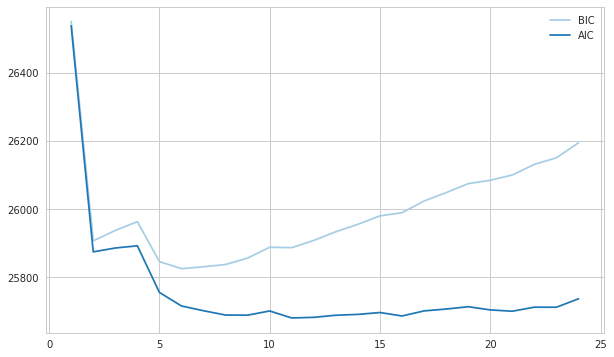

In [15]:
n_estimators = np.arange(1, 25)
clfs = [GaussianMixture(n, max_iter=1000).fit(x) for n in n_estimators]
bics = [clf.bic(x) for clf in clfs]
aics = [clf.aic(x) for clf in clfs]

plt.figure(figsize=(10, 6))
plt.plot(n_estimators, bics, label='BIC')
plt.plot(n_estimators, aics, label='AIC')
plt.legend();

<font color=red>It appears that for both the AIC and BIC, 4 components is preferred.</font>

Why not 7?

## Example: GMM For Outlier Detection

GMM is what's known as a **Generative Model**: it's a probabilistic model from which a dataset can be generated.
One thing that generative models can be useful for is **outlier detection**: we can simply evaluate the likelihood of each point under the generative model; the points with a suitably low likelihood (where "suitable" is up to your own bias/variance preference) can be labeld outliers.

Let's take a look at this by defining a new dataset with some outliers:

In [16]:
np.random.seed(0)

# Add 20 outliers
true_outliers = np.sort(np.random.randint(0, len(x_init), 20))
y = x_init.copy()
y[true_outliers] += 50 * np.random.randn(20)
y = y.reshape(-1, 1)

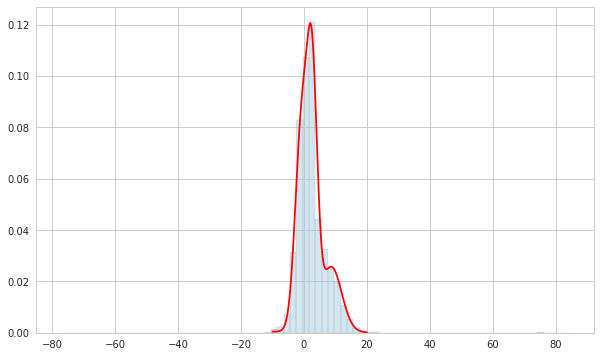

In [17]:
clf = GaussianMixture(5, max_iter=500, random_state=0).fit(y)
xpdf = np.linspace(-10, 20, 1000).reshape(-1, 1)
density_noise = np.exp(clf.score_samples(xpdf))

plt.figure(figsize=(10, 6))
plt.hist(y, 80, normed=True, alpha=0.5, ec='gray')
plt.plot(xpdf, density_noise, '-r');
# plt.xlim(-10, 20);

Now let's evaluate the log-likelihood of each point under the model, and plot these as a function of ``y``:

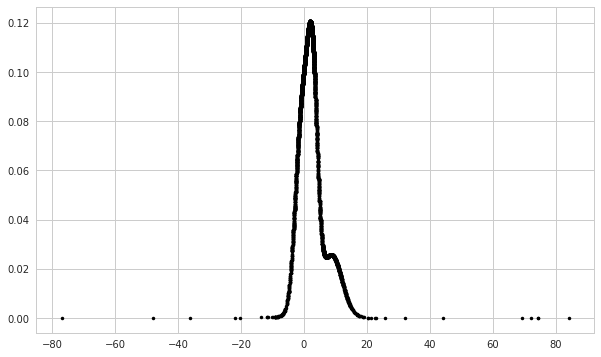

In [18]:
likelihood = np.exp(clf.score_samples(y))

plt.figure(figsize=(10, 6))
plt.plot(y, likelihood, '.k');

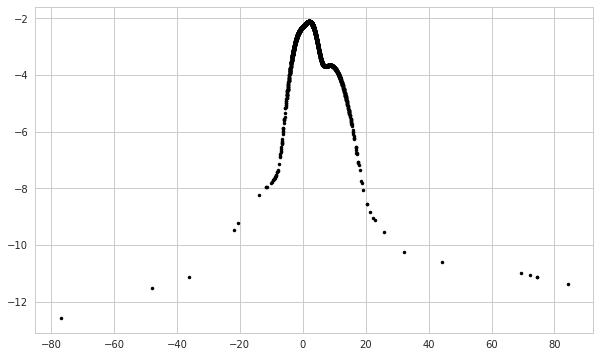

In [19]:
log_likelihood = clf.score_samples(y)

plt.figure(figsize=(10, 6))
plt.plot(y, log_likelihood, '.k');

In [20]:
detected_outliers = np.where(log_likelihood < -9)[0]

print("true outliers:")
print(true_outliers)
print("\ndetected outliers:")
print(detected_outliers)

true outliers:
[  99  537  705 1033 1653 1701 1871 2046 2135 2163 2222 2496 2599 2607
 2732 2893 2897 3264 3468 4373]

detected outliers:
[ 537  705 1653 2046 2130 2135 2163 2496 2724 2732 2893 2897 3067 3468
 4373]


The algorithm misses a few of these points, which is to be expected (some of the "outliers" actually land in the middle of the distribution!)

Here are the outliers that were missed:

In [21]:
set(true_outliers) - set(detected_outliers)

{99, 1033, 1701, 1871, 2222, 2599, 2607, 3264}

And here are the non-outliers which were spuriously labeled outliers:

In [22]:
set(detected_outliers) - set(true_outliers)

{2130, 2724, 3067}

Finally, we should note that although all of the above is done in one dimension, GMM does generalize to multiple dimensions, as we'll see in the breakout session.